In [ ]:
# mushroom_classification.ipynb

# 프로젝트 목적: 버섯(Mushroom) 데이터셋을 활용하여 독성 여부를 이진 분류하는 머신러닝 모델을 구축하고, 성능 평가 및 최적화하는 과정

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

In [ ]:
# 2. Load Data
# CSV 파일로부터 데이터를 불러온다.
df = pd.read_csv("Mushroomdata.csv")
# 컬럼 이름에 불필요한 공백이 있을 경우 제거
df.columns = df.columns.str.strip()

In [ ]:
# 3. Preprocessing
# 데이터셋 내 '?'로 표기된 결측치를 NaN으로 대체한 뒤 제거한다.
df = df.replace('?', np.nan)
df = df.dropna()

# 'Mushroom_quality' 컬럼을 타겟 변수로 설정하고, 나머지를 피처로 설정
X = df.drop('Mushroom_quality', axis=1)
y = df['Mushroom_quality']

# 범주형 데이터를 원-핫 인코딩하여 수치형으로 변환한다.
X_encoded = pd.get_dummies(X)
# 타겟 라벨을 독성(p: poisonous) 1, 식용(e: edible) 0으로 변환한다.
y_encoded = (y == 'p').astype(int)

# 데이터를 학습용과 테스트용으로 분할한다 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)


Baseline Model Performance:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       705
           1       1.00      1.00      1.00       424

    accuracy                           1.00      1129
   macro avg       1.00      1.00      1.00      1129
weighted avg       1.00      1.00      1.00      1129



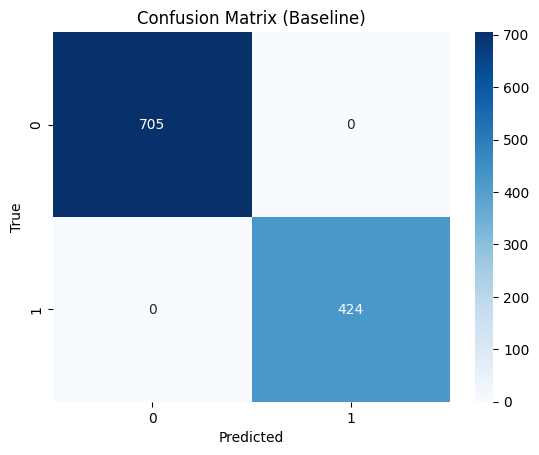

In [ ]:
# 4. Baseline Model Training
# RandomForestClassifier 기본 설정으로 모델을 학습시킨다.
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 테스트 데이터에 대해 예측을 수행한다.
y_pred = model.predict(X_test)

# 성능 평가: 기본 모델의 정확도, 정밀도, 재현율, F1-score 출력
print("\nBaseline Model Performance:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix 시각화
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Baseline)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# 5. Hyperparameter Tuning
# RandomForest 하이퍼파라미터 튜닝을 위해 그리드 탐색 설정
param_grid = {
    'n_estimators': [100, 200], # 트리 개수
    'max_depth': [5, 10, 15],   # 트리 최대 깊이
    'min_samples_split': [2, 5, 10] # 노드를 분할하기 위한 최소 샘플 수
}

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 탐색
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5, # 5-fold 교차 검증
    scoring='accuracy',
    n_jobs=-1
)

# 그리드 탐색 학습
grid_search.fit(X_train, y_train)
# 최적 하이퍼파라미터 출력
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}



Tuned Model Performance:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       705
           1       1.00      1.00      1.00       424

    accuracy                           1.00      1129
   macro avg       1.00      1.00      1.00      1129
weighted avg       1.00      1.00      1.00      1129



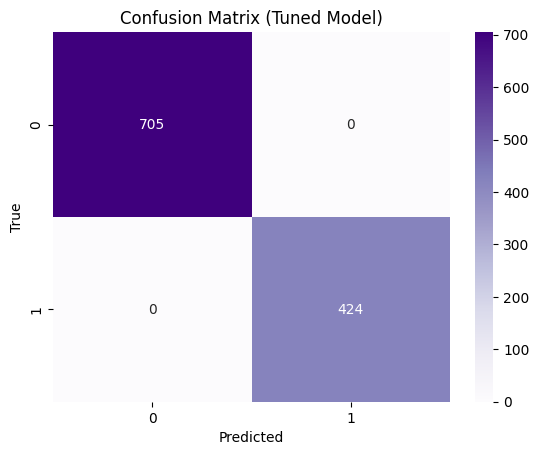

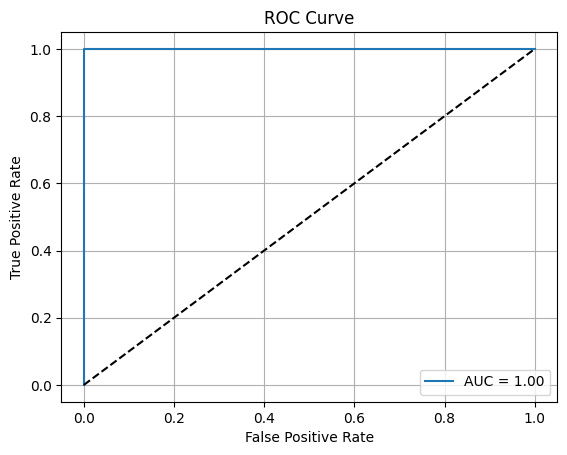

In [ ]:
# 6. Tuned Model Evaluation
# 찾은 최적 하이퍼파라미터를 적용한 모델로 재학습 및 평가
best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_test)

# 튜닝된 모델의 성능 출력
print("\nTuned Model Performance:\n")
print(classification_report(y_test, y_pred_best))

# 튜닝된 모델의 Confusion Matrix 시각화
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix (Tuned Model)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve 및 AUC 시각화
# 모델이 출력한 독성(1)일 확률을 가져온다.
y_prob_best = best_model.predict_proba(X_test)[:,1]

# ROC 커브를 그리기 위한 FPR, TPR 계산
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
auc_score = roc_auc_score(y_test, y_prob_best)

# ROC Curve 그리기
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()